In [112]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# Import Data

In [113]:
df_red_wine = pd.read_csv('src/winequality-red.csv',delimiter=';')
df_white_wine = pd.read_csv('src/winequality-white.csv',delimiter=';')

# Pre-processing

In [114]:
vals_red = dict(df_red_wine['quality'].value_counts())
vals_white = dict(df_white_wine['quality'].value_counts())
x_axis = list(range(11))
values = [[vals_red.get(elt) if vals_red.get(elt) != None else 0 for elt in x_axis],[vals_white.get(elt) if vals_white.get(elt) != None else 0 for elt in x_axis]]

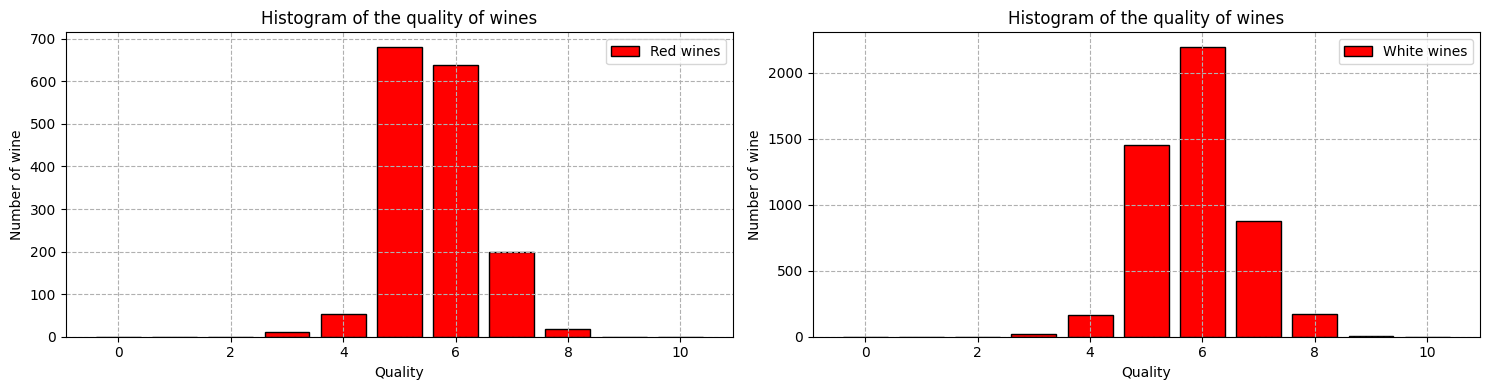

In [116]:
labels = ['Red wines','White wines']
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(15,4),sharey=False)
for i,val in enumerate(values):
    ax[i].bar(x_axis,height=val,color='r',edgecolor='k',label=labels[i])
    ax[i].set_xlabel('Quality')
    ax[i].set_ylabel('Number of wine')
    ax[i].grid(linestyle='--')
    ax[i].legend()
    ax[i].set_title('Histogram of the quality of wines')
    plt.tight_layout()
    ax[i].tick_params(axis='x', rotation=0)
plt.show()

The datasets classes are really imbalanced. The average qualities are dominating. To begin with, we will drop classes with less than **30** values.

In [117]:
r_square_red = df_red_wine.corr()['quality']**2

In [118]:
r_square_white = df_white_wine.corr()['quality']**2

In [120]:
pd.DataFrame(r_square_red.sort_values(ascending=False))

,quality
quality,1.000000
alcohol,0.226734
volatile acidity,0.152535
sulphates,0.063200
citric acid,0.051245
total sulfur dioxide,0.034262
density,0.030597
chlorides,0.016617
fixed acidity,0.015389
pH,0.003333


In [121]:
pd.DataFrame(r_square_white.sort_values(ascending=False))

,quality
quality,1.000000
alcohol,0.189725
density,0.094325
chlorides,0.044072
volatile acidity,0.037917
total sulfur dioxide,0.030533
fixed acidity,0.012919
pH,0.009886
residual sugar,0.009521
sulphates,0.002881


In [27]:
def customHeatmap(df):
    df = df.corr()
    df = df.applymap(lambda x: round(x,2))
    df = df.style.background_gradient(cmap='coolwarm')
    return df

In [30]:
customHeatmap(df_red_wine)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.260000,0.670000,0.110000,0.090000,-0.150000,-0.110000,0.670000,-0.680000,0.180000,-0.060000,0.120000
volatile acidity,-0.260000,1.000000,-0.550000,0.000000,0.060000,-0.010000,0.080000,0.020000,0.230000,-0.260000,-0.200000,-0.390000
citric acid,0.670000,-0.550000,1.000000,0.140000,0.200000,-0.060000,0.040000,0.360000,-0.540000,0.310000,0.110000,0.230000
residual sugar,0.110000,0.000000,0.140000,1.000000,0.060000,0.190000,0.200000,0.360000,-0.090000,0.010000,0.040000,0.010000
chlorides,0.090000,0.060000,0.200000,0.060000,1.000000,0.010000,0.050000,0.200000,-0.270000,0.370000,-0.220000,-0.130000
free sulfur dioxide,-0.150000,-0.010000,-0.060000,0.190000,0.010000,1.000000,0.670000,-0.020000,0.070000,0.050000,-0.070000,-0.050000
total sulfur dioxide,-0.110000,0.080000,0.040000,0.200000,0.050000,0.670000,1.000000,0.070000,-0.070000,0.040000,-0.210000,-0.190000
density,0.670000,0.020000,0.360000,0.360000,0.200000,-0.020000,0.070000,1.000000,-0.340000,0.150000,-0.500000,-0.170000
pH,-0.680000,0.230000,-0.540000,-0.090000,-0.270000,0.070000,-0.070000,-0.340000,1.000000,-0.200000,0.210000,-0.060000
sulphates,0.180000,-0.260000,0.310000,0.010000,0.370000,0.050000,0.040000,0.150000,-0.200000,1.000000,0.090000,0.250000


The correlation between the features and the quality is not the same depending on the type of wine. Since the correlation with many feature is weak, we will only keep the features with a $r^2 > 0.05$.

In [7]:
def uniform_sample(low:float,high:float)->float:
    return (high - low) * np.random.random_sample() + low

def dist_nearest_neighbor(df:pd.DataFrame,point:pd.DataFrame)->float:
    dist_min = float('inf')
    for row in df.values:
        dist = np.sqrt(sum([(val[0]-val[1])**2 for val in zip(row,point)]))
        if dist != 0 and dist < dist_min:
            dist_min = dist
    return dist

def hopkins_statistic(df:pd.DataFrame,m:int)->float:
    df_infos = dict(df.describe().loc[['min','max']])
    sample = df.sample(n=m).drop(['quality'],axis=1)
    uniform_data = pd.DataFrame(columns=df.columns[:-1])
    for _ in range(m):
        row = [uniform_sample(low=df_infos.get(feature).get('min'),high=df_infos.get(feature).get('max')) for feature in df.columns[:-1]]
        row = np.array(row).reshape(1,-1)
        row = pd.DataFrame(row,columns=df.columns[:-1])
        uniform_data = pd.concat([uniform_data,row])
    s_Q = sum([dist_nearest_neighbor(df,point) for point in uniform_data.values])
    s_P = sum([dist_nearest_neighbor(df,point) for point in sample.values])
    
    return s_Q/(s_Q + s_P)

In [122]:
hopkins_res_red = [hopkins_statistic(df_red_wine,nb) for nb in range(10,200,10)]
hopkins_res_white = [hopkins_statistic(df_white_wine,nb) for nb in range(10,200,10)]

KeyboardInterrupt: 

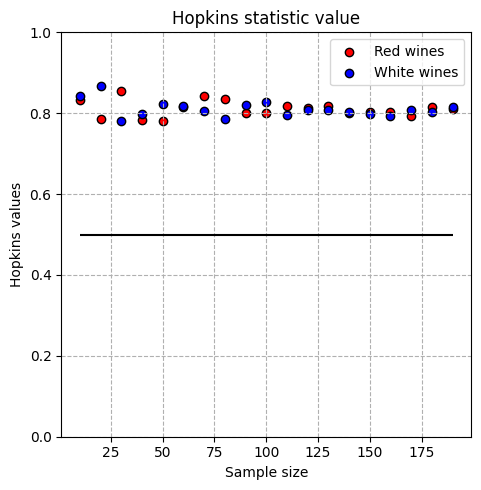

In [ ]:
vals = [hopkins_res_red,hopkins_res_white]
x_vals = [i for i in range(10,200,10)]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=False)
ax.scatter(x_vals,vals[0], color='r', edgecolor='k')
ax.scatter(x_vals,vals[1], color='b', edgecolor='k')
ax.set_xlabel('Sample size')
ax.set_ylabel('Hopkins values')
ax.grid(linestyle='--')
ax.hlines(y=0.5,xmin=min(x_vals),xmax=max(x_vals),color='k')
ax.set_title('Hopkins statistic value')
plt.tight_layout()
ax.tick_params(axis='x', rotation=0)
ax.set_ylim(ymin=0,ymax=1)
plt.legend(['Red wines','White wines'])
plt.show()

#### Drop features

In [123]:
# Drop uncorrelated features
feature_kept_red = list(r_square_red[r_square_red > 0.05].index)
feature_kept_white = list(r_square_white[r_square_white > 0.05].index)

df_red_wine_filtered = df_red_wine[feature_kept_red]
df_white_wine_filtered = df_white_wine[feature_kept_white]


# Drop classes with too few values
temp_red = df_red_wine_filtered['quality'].value_counts() >= 30
class_red = temp_red[temp_red == True].index

temp_white = df_white_wine_filtered['quality'].value_counts() >= 30
class_white = temp_white[temp_white == True].index

df_red_wine_filtered = df_red_wine_filtered[df_red_wine_filtered['quality'].isin(class_red)]
df_white_wine_filtered = df_white_wine_filtered[df_white_wine_filtered['quality'].isin(class_white)]




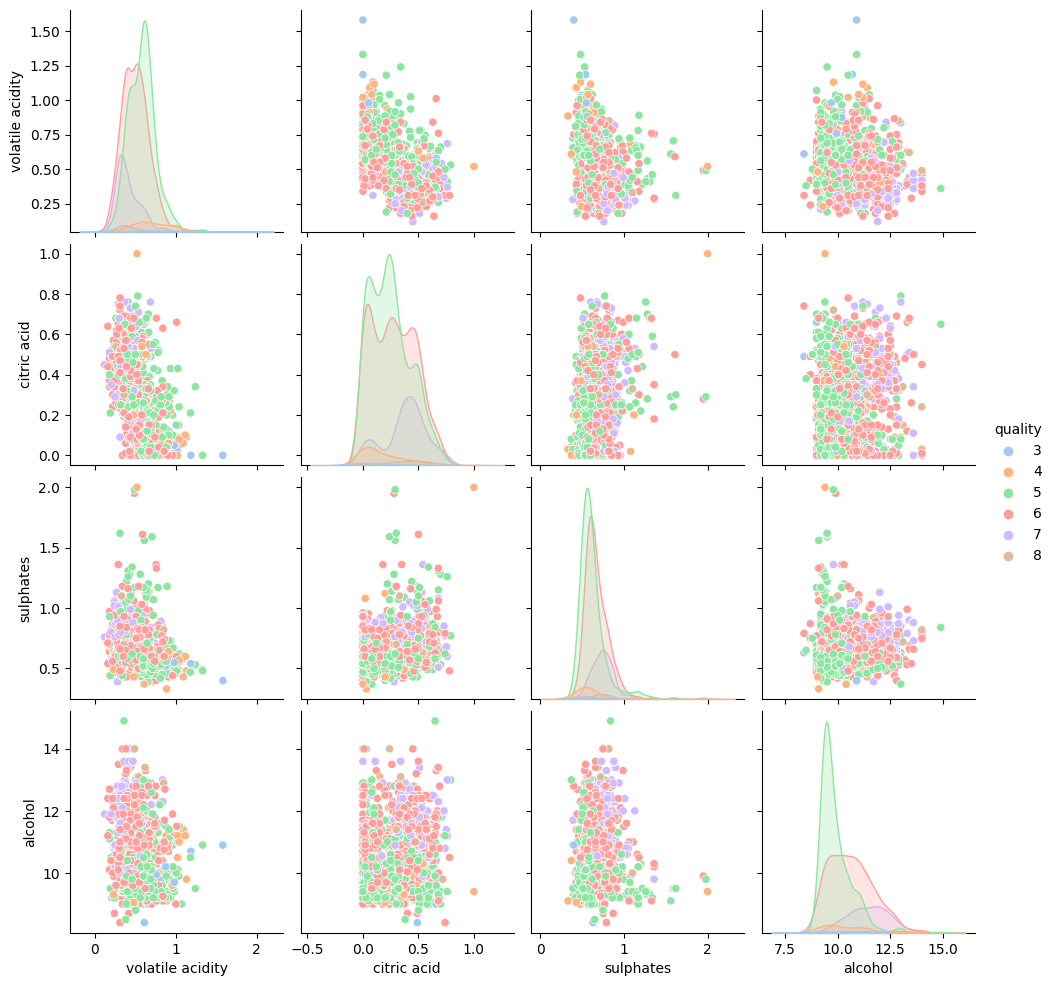

In [69]:
sns.pairplot(df_red_wine_filtered,hue='quality',palette='pastel')

From this visualisation we observe that it will be possible to do some clustering especially for qualities 5,6,7. The volatile acidity wrt alcohol representation is the most promising. It seems possible to cluster qualities 4,5,6,7,8 but using circular kernel like Kmeans might not fit the way we want.
According to the density histograms, only the alcohol feature will allow us to make some assumptions depending on the value.

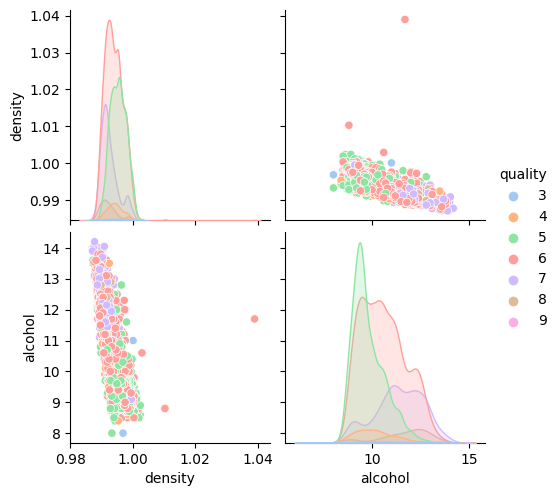

In [70]:
sns.pairplot(df_white_wine_filtered,hue='quality',palette='pastel')

For the white wine we have fewer features. The data seems to be on a straight line. Maybe it will be possible to do some regression.

# Model

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,Normalizer,RobustScaler,StandardScaler

from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor,BayesianRidge
from sklearn.svm import SVC,SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,f1_score,accuracy_score,make_scorer

from urllib.parse import urlparse

import mlflow.sklearn
import mlflow

In [254]:
wine_df = df_red_wine_filtered
train_df, test_df = train_test_split(wine_df,test_size=0.2)

y_train = train_df.pop("quality")

# convert the dataframe values to array
X_train = train_df.values

# Extracting the label column
y_test = test_df.pop("quality")

# convert the dataframe values to array
X_test = test_df.values

# Supervised 

In [124]:
scalers = [None,MinMaxScaler(),Normalizer(),RobustScaler(),StandardScaler()]
regressors = [LinearRegression(),Ridge(),SGDRegressor(),BayesianRidge(),SVR()]
classifiers = [SVC()]

In [164]:
def custom_score_reg(y_true, y_pred):
    count = 0
    for elt in zip(y_true,y_pred):
        if np.abs(elt[0]-round(elt[1],0)) <=0:
            count += 1
    return count/len(y_test)

In [275]:
scores = {reg:[] for reg in regressors}
pipes = []
for regressor in regressors:
    for scaler in scalers:
        pipes.append(Pipeline([('scaler', scaler), ('reg', regressor)]))      
        
for _, pipe in enumerate(pipes):
    pipe.fit(X_train, y_train)
    scores[pipe['reg']].append(custom_score_reg(y_test, pipe.predict(X_test)))
    # scores[pipe['reg']].append(mean_squared_error(y_test, pipe.predict(X_test)))
    print(pipe['scaler'],pipe['reg'],custom_score_reg(y_test, pipe.predict(X_test)))
    # print(pipe['scaler'],pipe['reg'],pipe.score(X_test, y_test))

None LinearRegression() 0.5650793650793651
MinMaxScaler() LinearRegression() 0.5650793650793651
Normalizer() LinearRegression() 0.5142857142857142
RobustScaler() LinearRegression() 0.5650793650793651
StandardScaler() LinearRegression() 0.5650793650793651
None Ridge() 0.5555555555555556
MinMaxScaler() Ridge() 0.5619047619047619
Normalizer() Ridge() 0.4603174603174603
RobustScaler() Ridge() 0.5650793650793651
StandardScaler() Ridge() 0.5650793650793651
None SGDRegressor() 0.5555555555555556
MinMaxScaler() SGDRegressor() 0.5206349206349207
Normalizer() SGDRegressor() 0.4222222222222222
RobustScaler() SGDRegressor() 0.5523809523809524
StandardScaler() SGDRegressor() 0.5619047619047619
None BayesianRidge() 0.5555555555555556
MinMaxScaler() BayesianRidge() 0.5714285714285714
Normalizer() BayesianRidge() 0.5111111111111111
RobustScaler() BayesianRidge() 0.5714285714285714
StandardScaler() BayesianRidge() 0.5714285714285714
None SVR() 0.5365079365079365
MinMaxScaler() SVR() 0.5492063492063493


In [276]:
print('\\begin{table}[h] \n \\centering \n \\begin{tabular}{|c|c|c|}')
print('Model & Scaler & Score \\\\ \\hline')
for k,v in scores.items():
    print(f'{k} & {scalers[np.argmax(v)]} & {round(np.max(v),4)} \\\\')
print('\\hline \n \\end{tabular} \n \\end{table}')

\begin{table}[h] 
 \centering 
 \begin{tabular}{|c|c|c|}
Model & Scaler & Score \\ \hline
LinearRegression() & None & 0.5651 \\
Ridge() & RobustScaler() & 0.5651 \\
SGDRegressor() & StandardScaler() & 0.5619 \\
BayesianRidge() & MinMaxScaler() & 0.5714 \\
SVR() & MinMaxScaler() & 0.5492 \\
\hline 
 \end{tabular} 
 \end{table}


In [125]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    return rmse, mae, r2


In [69]:
mlflow.set_tracking_uri("http://localhost:5000/")
mlflow.set_experiment("Project Data Mining")

<Experiment: artifact_location='mlflow-artifacts:/2', creation_time=1669629979912, experiment_id='2', last_update_time=1669629979912, lifecycle_stage='active', name='Project Data Mining', tags={}>

In [79]:
# This cell used MLflow to log the model and the parameters used to train it, it needs an active MLflow sqlite server to run
pipes = []
scores = []

for scaler in scalers:
    for regressor in regressors:
        pipes.append(Pipeline([('scaler', scaler), ('reg', regressor)]))

for scaler in scalers:
    for classifier in classifiers:
        pipes.append(Pipeline([('scaler', scaler), ('classif', classifier)]))

for i, pipe in enumerate(pipes):
    print(pipe)
    with mlflow.start_run():
        mlflow.set_tag("mlflow.runName", f'white wine : {i}')
        pipe.fit(X_train, y_train)
        predicted_qualities = pipe.predict(X_test)
        rmse, mae, r2 = eval_metrics(y_test, predicted_qualities)
        mlflow.log_param("scaler", f'{pipe["scaler"]}')
        try:
            mlflow.log_param("reg", f'{pipe["reg"]}')
        except KeyError:
            pass
        try:
            mlflow.log_param("classif", f'{pipe["classif"]}')
        except KeyError:
            pass 
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mae", mae)
        mlflow.log_metric("accuracy", pipe.score(X_test, y_test))

Pipeline(steps=[('scaler', None), ('reg', LinearRegression())])
Pipeline(steps=[('scaler', None), ('reg', Ridge())])
Pipeline(steps=[('scaler', None), ('reg', SGDRegressor())])
Pipeline(steps=[('scaler', None), ('reg', BayesianRidge())])
Pipeline(steps=[('scaler', None), ('reg', SVR())])
Pipeline(steps=[('scaler', MinMaxScaler()), ('reg', LinearRegression())])
Pipeline(steps=[('scaler', MinMaxScaler()), ('reg', Ridge())])
Pipeline(steps=[('scaler', MinMaxScaler()), ('reg', SGDRegressor())])
Pipeline(steps=[('scaler', MinMaxScaler()), ('reg', BayesianRidge())])
Pipeline(steps=[('scaler', MinMaxScaler()), ('reg', SVR())])
Pipeline(steps=[('scaler', Normalizer()), ('reg', LinearRegression())])
Pipeline(steps=[('scaler', Normalizer()), ('reg', Ridge())])
Pipeline(steps=[('scaler', Normalizer()), ('reg', SGDRegressor())])
Pipeline(steps=[('scaler', Normalizer()), ('reg', BayesianRidge())])
Pipeline(steps=[('scaler', Normalizer()), ('reg', SVR())])
Pipeline(steps=[('scaler', RobustScaler()),

In [261]:
def custom_score(y_true, y_pred):
    count = 0
    for elt in zip(y_true,y_pred):
        if np.abs(elt[0]-elt[1]) <=0:
            count += 1
    return count/len(y_test)

In [258]:
custom_scorer = make_scorer(custom_score, greater_is_better=True)

In [277]:
params_tree = {'clf__criterion':['gini', 'entropy'],
          'clf__splitter':['best', 'random'],
            'clf__max_depth':list(range(2,200,5)),
             'clf__min_samples_split' : list(range(5,50,5))
         }

In [279]:
scores = {scaler:[] for scaler in scalers}
pipes = []
for scaler in scalers:
    pipes.append(Pipeline([('scaler', scaler), ('clf', DecisionTreeClassifier())]))      
        
for _, pipe in enumerate(pipes):
    clf = GridSearchCV(pipe,params_tree,cv=5)
    clf.fit(X_train,y_train)
    scores[pipe['scaler']].append(clf.score(X_test, y_test))
    # scores[pipe['reg']].append(mean_squared_error(y_test, pipe.predict(X_test)))
    print(pipe['scaler'],clf.score(X_test, y_test))
    # print(pipe['scaler'],pipe['reg'],pipe.score(X_test, y_test))



None 0.5619047619047619
MinMaxScaler() 0.5396825396825397
Normalizer() 0.580952380952381
RobustScaler() 0.5777777777777777
StandardScaler() 0.5238095238095238


In [281]:
print('\\begin{table}[h] \n \\centering \n \\begin{tabular}{|c|c|c|}')
print('Model & Scaler & Score \\\\ \\hline')
for k,v in scores.items():
    print(f'{k} & {v[0]} \\\\')
print('\\hline \n \\end{tabular} \n \\end{table}')

\begin{table}[h] 
 \centering 
 \begin{tabular}{|c|c|c|}
Model & Scaler & Score \\ \hline
None & 0.5619047619047619 \\
MinMaxScaler() & 0.5396825396825397 \\
Normalizer() & 0.580952380952381 \\
RobustScaler() & 0.5777777777777777 \\
StandardScaler() & 0.5238095238095238 \\
\hline 
 \end{tabular} 
 \end{table}


There is too much variability with a single decision tree. From one run to another the best parameters can completly change. The best score we have reached is 56%. We will try too smooth the results with a random forest.

In [282]:
params_forest = {'clf__n_estimators': list(range(10, 20, 10)),
                 'clf__criterion': ['gini', 'entropy'],
                 'clf__max_depth': list(range(2, 100, 10)),
                 'clf__min_samples_split': list(range(5, 50, 5))
                 }

In [284]:
scores = {scaler:[] for scaler in scalers}
pipes = []
for scaler in scalers:
    pipes.append(Pipeline([('scaler', scaler), ('clf', RandomForestClassifier())]))      
        
for _, pipe in enumerate(pipes):
    clf = GridSearchCV(pipe,params_forest,cv=5)
    clf.fit(X_train,y_train)
    scores[pipe['scaler']].append(clf.score(X_test, y_test))
    # scores[pipe['reg']].append(mean_squared_error(y_test, pipe.predict(X_test)))
    print(pipe['scaler'],clf.score(X_test, y_test))
    # print(pipe['scaler'],pipe['reg'],pipe.score(X_test, y_test))



None 0.6031746031746031
MinMaxScaler() 0.5904761904761905
Normalizer() 0.6190476190476191
RobustScaler() 0.5650793650793651
StandardScaler() 0.6031746031746031


In [288]:
print('\\begin{table}[h] \n \\centering \n \\begin{tabular}{c|c}')
print('Scaler & Score \\\\ \\hline')
for k,v in scores.items():
    print(f'{k} & {round(v[0],3)} \\\\')
print('\\end{tabular} \n \\caption{Random forest scores} \n \\end{table}')

\begin{table}[h] 
 \centering 
 \begin{tabular}{c|c}
Scaler & Score \\ \hline
None & 0.603 \\
MinMaxScaler() & 0.59 \\
Normalizer() & 0.619 \\
RobustScaler() & 0.565 \\
StandardScaler() & 0.603 \\
\end{tabular} 
 \caption{Random forest scores} 
 \end{table}


In [226]:
def custom_score2(y_true, y_pred,eps):
    count = 0
    for elt in zip(y_true,y_pred):
        if round(elt[1]+eps,0) == elt[0] or round(elt[1]-eps,0) == elt[0]:
            count += 1
    return count/len(y_test)

In [290]:
pipe = Pipeline([('scaler', None), ('reg', LinearRegression())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', None), ('reg', LinearRegression())])

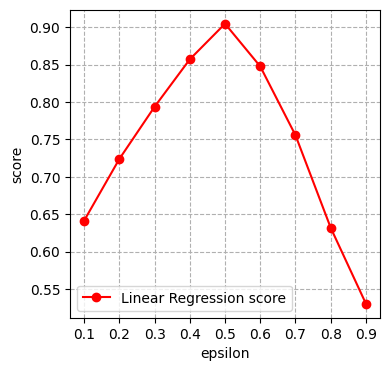

In [291]:
eps = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
_, ax = plt.subplots(figsize=(4, 4))
ax.plot(eps, [custom_score2(y_test,pipe.predict(X_test),elt) for elt in eps], 'o-',color='r',label='Linear Regression score')
ax.grid(linestyle='--')
ax.set_xlabel('epsilon')
ax.set_ylabel('score')
ax.set_xticks(eps)
# ax.set_ylim(0,1)
ax.legend(loc='best')